In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
# by default colab has pandas 1.1.5 installed, pickle reading below requires same version as when writing, i.e. 1.3
!pip install pandas==1.3

# colab uses python 3.7, use pickle5 to make pickle processes compatible across versions
!pip install pickle5

In [3]:
# relative imports are painful in colab, copy all needed functions into this file
# colab uses python 3.7 => need List[str] instead of list[str]

import time
import pickle5 as pickle
from dataclasses import dataclass, field
from typing import Any, Optional, Union, List, Tuple
from io import BytesIO
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import pandas as pd
import requests
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms
from torchvision.models import resnet18
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, Dataset, Subset, random_split


In [4]:
# change paths for running on Colab

### replace by individual path to project folder ###
base_path = Path("/content/gdrive/Othercomputers/Mein Laptop/airbnb-oslo")

data_path = base_path / "data-clean"
listings_path = data_path / "listings.pkl"
pictures_path = data_path / "front_page_pictures.pkl"

with open(listings_path, "rb") as f:
    listings_df = pickle.load(f)

with open(pictures_path, "rb") as f:
    front_page_pictures = pickle.load(f)

In [34]:
@dataclass
class ResultContainer:
    """
    Collects all Results of Interest after the Model Fitting Step in a single Object and displays them in a Pandas DataFrame
    """

    model_names: List[str] = field(default_factory=list)
    train_mae_list: List[float] = field(default_factory=list)
    val_mae_list: List[float] = field(default_factory=list)
    train_r2_list: List[float] = field(default_factory=list)
    val_r2_list: List[float] = field(default_factory=list)
    train_mse_list: List[float] = field(default_factory=list)
    val_mse_list: List[float] = field(default_factory=list)
    hyperparam_keys: List[str] = field(default_factory=list)
    hyperparam_values: List[float] = field(default_factory=list)
    num_features: List[float] = field(default_factory=list)
    feature_selector: List[float] = field(default_factory=list)
    log_y: List[bool] = field(default_factory=list)

    def append(
        self,
        train_mae: float,
        val_mae: float,
        train_r2: float,
        val_r2: float,
        train_mse: float,
        val_mse: float,
        hyperparam_key: Optional[Union[str, List[str]]] = None,
        hyperparam_value: Optional[Union[str, float, List[float]]] = None,
        num_features: Optional[int] = None,
    ):
        self.train_mae_list.append(train_mae)
        self.val_mae_list.append(val_mae)
        self.train_r2_list.append(train_r2)
        self.val_r2_list.append(val_r2)
        self.train_mse_list.append(train_mse)
        self.val_mse_list.append(val_mse)

        if hyperparam_key is not None:
            self.hyperparam_keys.append(hyperparam_key)
        if hyperparam_value is not None:
            self.hyperparam_values.append(hyperparam_value)
        if num_features is not None:
            self.num_features.append(num_features)

    def display_df(self) -> pd.DataFrame:
        metrics_df = pd.DataFrame(
            {
                "mae_train": self.train_mae_list,
                "mae_val": self.val_mae_list,
                "r2_train": self.train_r2_list,
                "r2_val": self.val_r2_list,
                "mse_train": self.train_mse_list,
                "mse_val": self.val_mse_list,
                "hyperparam_keys": self.hyperparam_keys,
                "hyperparam_values": self.hyperparam_values,
                "num_features": self.num_features,
                "feature_selector": self.feature_selector,
                "log_y": self.log_y,
            },
            index=self.model_names,
        )

        return metrics_df.sort_values("mae_val")

def generate_train_val_data_split(
    full_dataset: Dataset, split_seed: int = 123, val_frac: float = 0.2
) -> Tuple[Dataset, Dataset]:
    """
    Splits the entire Dataset used for Model Training into a Training Set and Validation Set.
    The relative Sizes of each Output Component can be specified with a fractional Value between 0 and 1.
    """

    num_val_samples = np.ceil(val_frac * len(full_dataset)).astype(int)
    num_train_samples = len(full_dataset) - num_val_samples
    trainset, valset = random_split(
        dataset=full_dataset,
        lengths=(num_train_samples, num_val_samples),
        generator=torch.Generator().manual_seed(split_seed),
    )
    return trainset, valset

@dataclass
class NeuralNetMetrics:
    """
    Tracks Performance Metrics for all Epochs during Model Training.
    This is particularly useful to plot Loss Curves of the Mean Squared Error, Mean Absolute Error and R^2 Value on Training and Validation Set after Training is completed.
    """

    train_losses: List[str] = field(default_factory=list)
    val_losses: List[float] = field(default_factory=list)
    train_maes: List[float] = field(default_factory=list)
    val_maes: List[float] = field(default_factory=list)
    train_r2s: List[float] = field(default_factory=list)
    val_r2s: List[float] = field(default_factory=list)

    def append(
        self,
        train_loss: float,
        val_loss: float,
        train_mae: float,
        val_mae: float,
        train_r2: float,
        val_r2: float,
    ):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.train_maes.append(train_mae)
        self.val_maes.append(val_mae)
        self.train_r2s.append(train_r2)
        self.val_r2s.append(val_r2)

    def plot(self):
        sns.set_theme(style="whitegrid")

        fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(9, 9))

        epochs = range(1, len(self.train_losses) + 1)

        ax1.plot(epochs, self.train_losses, label="Training") #, marker="o")
        ax1.plot(epochs, self.val_losses, label="Validation") #, marker="o")
        ax1.set(
            title="Mean Squared Error",
            xlabel="",
            ylabel="",
        )
        ax1.legend()

        ticks_loc = ax1.get_yticks().tolist()
        ax1.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
        ax1.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc])

        ax2.plot(epochs, self.train_maes, label="Training")#, marker="o")
        ax2.plot(epochs, self.val_maes, label="Validation")#, marker="o")
        ax2.set(
            title="Mean Absolute Error",
            xlabel="",
            ylabel="",
        )

        ax3.plot(epochs, self.train_r2s, label="Training")#, marker="o")
        ax3.plot(epochs, self.val_r2s, label="Validation")#, marker="o")
        ax3.set(
            title="R2",
            xlabel="Epoch",
            ylabel="",
        )

        fig.tight_layout()
        sns.move_legend(
            obj=ax1, loc="upper center", bbox_to_anchor=(1.1, -0.7), frameon=False
        )

        sns.despine()
        plt.show()


def init_weights(layer: nn.Module, mean: float = 0, std: float = 1):
    """
    Initializes Model Weights at the Start of Training.
    Avoids negative predicted Prices during the first Epochs to take the Logarithm when training with Log-Prices.
    """

    if isinstance(layer, nn.Linear):
        # avoid negative predicted prices at beginning of training to enable log transformation
        torch.nn.init.normal_(layer.weight, mean=mean, std=std)


def train_regression(
    dataloader: DataLoader,
    optimizer: Union[Adam, SGD],
    model: Any,
    loss_function: nn.MSELoss,
    device: torch.device,
    log_y: bool = False,
) -> Tuple[float, float, float]:
    """
    Model Training and Weight Adjustment Step on the Training Set for a single Epoch.
    Returns Mean Squared Error, Mean Absolute Error and R^2 Value for this Epoch on the Training Set.
    """

    # calculate mean squared error, mean_absolute error and r2 with values of all batches to perform comparable computations as with classical models
    y_true_list = []
    y_pred_list = []

    model.train()
    for x, y in dataloader:
        x = x.to(device=device)
        y = y.to(device=device)

        optimizer.zero_grad()
        y_pred = model(x).squeeze()

        # train model / backpropagate loss on log scale
        if log_y:
            y = torch.log(y)
            y_pred = torch.log(y_pred)

        loss = loss_function(y_pred, y)
        loss.backward()
        optimizer.step()

        # collect error metrics on original scale
        if log_y:
            y = torch.exp(y)
            y_pred = torch.exp(y_pred)

        y_true_list.extend(list(y.detach().cpu()))
        y_pred_list.extend(list(y_pred.detach().cpu()))

    mse = mean_squared_error(y_true_list, y_pred_list)
    mae = mean_absolute_error(y_true_list, y_pred_list)
    r2 = r2_score(y_true_list, y_pred_list)

    return mse, mae, r2


def validate_regression(
    dataloader: DataLoader, model: Any, device: torch.device
) -> Tuple[float, float, float]:
    """
    Evaluation Step on the Validation Set for a single Epoch.
    Returns Mean Squared Error, Mean Absolute Error and R^2 Value for this Epoch on the Validation Set.
    """

    y_true_list = []
    y_pred_list = []

    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device=device, dtype=torch.float)
            y = y.to(device=device, dtype=torch.float)

            y_pred = model(x).squeeze()

            y_true_list.extend(list(y.detach().cpu()))
            y_pred_list.extend(list(y_pred.detach().cpu()))

    mse = mean_squared_error(y_true_list, y_pred_list)
    mae = mean_absolute_error(y_true_list, y_pred_list)
    r2 = r2_score(y_true_list, y_pred_list)

    return mse, mae, r2


def print_epoch(
    epoch: int,
    num_epochs: int,
    epoch_train_mse: float,
    epoch_val_mse: float,
    epoch_train_mae: float,
    epoch_val_mae: float,
    epoch_train_r2: float,
    epoch_val_r2: float,
    scheduler: Optional[Any] = None,
):
    """
    Prints Information about the Model Performance in Training and Validation Set of the current Epoch while the Model is trained.
    """

    print(f"Epoch: {epoch} / {num_epochs}\n{'-' * 50}")
    if scheduler is not None:
        print(f"Learning Rate: {scheduler.state_dict()['_last_lr'][0]:.1e}")
    print(
        f"Mean MSE Training: {epoch_train_mse:.3f} | Mean MSE Validation: {epoch_val_mse:.3f}\n"
        f"Mean MAE Training: {epoch_train_mae:.3f} | Mean MAE Validation: {epoch_val_mae:.3f}\n"
        f"Mean R2 Training: {epoch_train_r2:.3f} | Mean R2 Validation: {epoch_val_r2:.3f}\n"
    )


def print_best(
    best_train_mae: float,
    best_train_mae_epoch: int,
    best_val_mae: float,
    best_val_mae_epoch: int,
):
    """
    Prints the lowest Mean Absolute Error of the Training and Validation Set encountered during Model Training after Training is completed.
    """

    print(
        f"\nBest Mean MAE Training: {best_train_mae:.3f} (Epoch {best_train_mae_epoch})"
        f"\nBest Mean MAE Validation: {best_val_mae:.3f} (Epoch {best_val_mae_epoch})"
    )


def run_regression(
    model: Any,
    optimizer: Union[Adam, SGD],
    loss_function: nn.MSELoss,
    device: torch.device,
    num_epochs: int,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    result_container: Optional[ResultContainer] = None,
    log_y: bool = False,
    scheduler: Optional[Any] = None,
    save_best: bool = False,
    save_path: bool = None,
    verbose: bool = False,
) -> Union[Tuple[NeuralNetMetrics, ResultContainer], NeuralNetMetrics]:
    """
    Trains a Neural Network Regression Model for a specified number of Epochs.
    During Training Performance Information is displayed.
    Optionally the State with the lowest Mean Absolute Error can be tracked and saved.

    Returns a NeuralNetMetrics Object for plotting Loss Curves and optionally a ResultContainer Object to collect the Results in a Pandas DataFrame for Comparison with the Classical Statistical Models.
    """

    start_time = time.perf_counter()

    if result_container is not None:
        result_container.log_y.append(log_y)
    metrics = NeuralNetMetrics()

    if save_best:
        # use mean absolute error as metric for early stopping
        best_train_mae = np.inf
        best_val_mae = np.inf

    for epoch in range(1, num_epochs + 1):

        epoch_train_mse, epoch_train_mae, epoch_train_r2 = train_regression(
            dataloader=train_dataloader,
            optimizer=optimizer,
            model=model,
            loss_function=loss_function,
            device=device,
            log_y=log_y,
        )

        if scheduler is not None:
            scheduler.step()

        epoch_val_mse, epoch_val_mae, epoch_val_r2 = validate_regression(
            dataloader=val_dataloader,
            model=model,
            device=device,
        )

        metrics.append(
            epoch_train_mse,
            epoch_val_mse,
            epoch_train_mae,
            epoch_val_mae,
            epoch_train_r2,
            epoch_val_r2,
        )

        if save_best:
            if epoch_train_mae < best_train_mae:
                best_train_mae_epoch = epoch
                best_train_mae = epoch_train_mae

            if epoch_val_mae < best_val_mae:
                best_val_mae_epoch = epoch
                best_val_mae = epoch_val_mae

                # save weights for lowest validation mae
                if save_path is not None:
                    torch.save(model.state_dict(), save_path)

        if verbose:
            if epoch % int(num_epochs / 5) == 0:
                print_epoch(
                    epoch,
                    num_epochs,
                    epoch_train_mse,
                    epoch_val_mse,
                    epoch_train_mae,
                    epoch_val_mae,
                    epoch_train_r2,
                    epoch_val_r2,
                    scheduler,
                )

    time_elapsed = np.round(time.perf_counter() - start_time, 0).astype(int)
    print(f"Finished training after {time_elapsed} seconds.")

    # check twice for save_best to include both cases for result_container is None and result_container is not None
    if save_best:
        print_best(
            best_train_mae, best_train_mae_epoch, best_val_mae, best_val_mae_epoch
        )

    if result_container is None:
        return metrics

    if save_best:
        # if save_best=True save results from epoch with best validation mae (starts at epoch=1)
        result_container.append(
            metrics.train_maes[best_val_mae_epoch - 1],
            metrics.val_maes[best_val_mae_epoch - 1],
            metrics.train_r2s[best_val_mae_epoch - 1],
            metrics.val_r2s[best_val_mae_epoch - 1],
            metrics.train_losses[best_val_mae_epoch - 1],
            metrics.val_losses[best_val_mae_epoch - 1],
        )
    else:
        # if save_best=False save result from last epoch (starts at epoch=1)
        result_container.append(
            metrics.train_maes[epoch - 1],
            metrics.val_maes[epoch - 1],
            metrics.train_r2s[epoch - 1],
            metrics.val_r2s[epoch - 1],
            metrics.train_losses[epoch - 1],
            metrics.val_losses[epoch - 1],
        )

    return metrics, result_container

  

In [35]:
front_page_pictures

id
42932    <PIL.JpegImagePlugin.JpegImageFile image mode=...
42932    <PIL.JpegImagePlugin.JpegImageFile image mode=...
42932    <PIL.JpegImagePlugin.JpegImageFile image mode=...
42932    <PIL.JpegImagePlugin.JpegImageFile image mode=...
42932    <PIL.JpegImagePlugin.JpegImageFile image mode=...
69964    <PIL.JpegImagePlugin.JpegImageFile image mode=...
69964    <PIL.JpegImagePlugin.JpegImageFile image mode=...
69964    <PIL.JpegImagePlugin.JpegImageFile image mode=...
69964    <PIL.JpegImagePlugin.JpegImageFile image mode=...
69964    <PIL.JpegImagePlugin.JpegImageFile image mode=...
Name: listing_url, dtype: object

In [36]:
listings_df = listings_df.iloc[:10]

# drop prices of 0, largest price (outlier) and missing images
picture_price_df = (
    pd.merge(
        front_page_pictures, listings_df["price"], left_index=True, right_index=True
    )
    .loc[lambda x: (x["price"] > 0) & (x["price"] < 80000)]
    .dropna()
)


In [37]:
IMAGE_SIZE = [224, 224]
batch_size = 128

image_transforms = transforms.Compose(
    [transforms.Resize(size=IMAGE_SIZE), transforms.PILToTensor()]
)

# normalization requires four dimensions, done after unsqueezing
# values of channel means and standard deviations from documentation for resnet https://pytorch.org/vision/stable/models.html
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


In [38]:
device = torch.device(device="cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [39]:
class ListingsImages(Dataset):
    """
    Creates PyTorch Dataset from Pandas DataFrame containing (at least) one Column of Picture URLs and one additional Column of corresponding Prices.
    The resulting Images are resized and normalized four-dimensional Tensors and serve, together with the returned Price Tensors, as Input to a PyTorch DataLoader object.
    """

    def __init__(self, df, image_transforms=None):
        self.x = df["listing_url"]
        self.y = torch.tensor(df["price"].values, dtype=torch.float)
        self.image_transforms = image_transforms

    def __getitem__(self, index):
        img = self.x.iloc[index]
        label = self.y[index]

        if self.image_transforms is not None:
            img_tensor = self.image_transforms(img).to(dtype=torch.float)
            img_tensor = normalize(img_tensor)

        return img_tensor, label

    def __len__(self):
        return len(self.y)



In [40]:
full_dataset = ListingsImages(picture_price_df, image_transforms)
trainset, valset = generate_train_val_data_split(full_dataset)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True)

In [41]:
model = resnet18(pretrained=True)

# freeze weights
for param in model.parameters():
    param.requires_grad = False

# replace last fully connected layer, weights of new layer require gradient computation
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 1)

model.to(device=device)

params_to_update = [param for param in model.parameters() if param.requires_grad]

lr = 0.01
num_epochs = 50
save_path = base_path / "models/cnn_weights.pt"

# use only parameters with requires_grad = True in optimizer
optimizer = optim.Adam(params_to_update, lr=lr)
loss_function = nn.MSELoss()

result_container = ResultContainer()

metrics = run_regression(
    model,
    optimizer,
    loss_function,
    device,
    num_epochs,
    trainloader,
    valloader,
    verbose=True,
    save_best=True,
    save_path=save_path
) 

Epoch: 10 / 50
--------------------------------------------------
Mean MSE Training: 2664273.000 | Mean MSE Validation: 713101.375
Mean MAE Training: 1541.639 | Mean MAE Validation: 844.449
Mean R2 Training: -8.226 | Mean R2 Validation: 0.000

Epoch: 20 / 50
--------------------------------------------------
Mean MSE Training: 2524217.000 | Mean MSE Validation: 629698.188
Mean MAE Training: 1495.971 | Mean MAE Validation: 793.526
Mean R2 Training: -7.741 | Mean R2 Validation: 0.000

Epoch: 30 / 50
--------------------------------------------------
Mean MSE Training: 2389547.250 | Mean MSE Validation: 557873.062
Mean MAE Training: 1450.719 | Mean MAE Validation: 746.865
Mean R2 Training: -7.275 | Mean R2 Validation: 0.000

Epoch: 40 / 50
--------------------------------------------------
Mean MSE Training: 2260545.250 | Mean MSE Validation: 490513.594
Mean MAE Training: 1406.021 | Mean MAE Validation: 700.271
Mean R2 Training: -6.828 | Mean R2 Validation: 0.000

Epoch: 50 / 50
---------

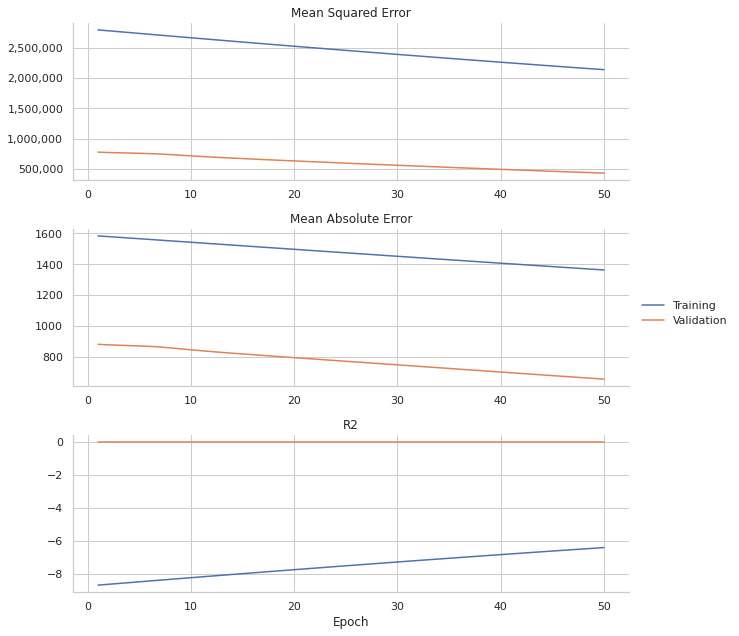

In [42]:
metrics.plot()

In [43]:
# make predictions on entire dataset, set shuffle to False to keep same order as in original dataframe
dataloader = DataLoader(full_dataset, batch_size=len(full_dataset), shuffle=False)
images, prices = next(iter(dataloader))
images = images.to(device=device)

with torch.no_grad():
  predicted_prices = model(images)

In [55]:
predictions_series = pd.Series(predicted_prices.detach().cpu().numpy().squeeze(), index = picture_price_df.index)
predictions_series

id
42932    212.565475
42932    247.352890
42932    211.202194
42932    241.901672
42932    231.418076
69964    249.353226
69964    220.035309
69964    220.487778
69964    214.068100
69964    214.474304
dtype: float32

In [58]:
predictions_series.to_pickle(base_path / "data-clean/cnn_predictions.pkl")